In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import illustris_python as il
from matplotlib.gridspec import GridSpec

In [2]:
def Distance_1D(X, X_POS, BoxSize):
    '''This function takes as input a 1D 
    vector containing the positions of particles, 
    the X_POS(float) that is the position respect 
    to where we will compute the Distance and the BoxSize, 
    this function consider a periodical Box. 
    The output is a 1D vector with the same size than X 
    containing the distance from X to X_POS
    example:
        xc = Distance_1D(pos[gals,0], pos[central,0], (75000/h))
        yc = Distance_1D(pos[gals,1], pos[central,1], (75000/h))
        zc = Distance_1D(pos[gals,2], pos[central,2], (75000/h))
        # with the aim of use of the normpos
        normpos = np.sqrt(xc**2 + yc**2 + zc**2)/r200[group]
    '''
    
    D=X-X_POS
    D=np.where(D>BoxSize/2, D-BoxSize, D)
    D=np.where(D<-BoxSize/2, D+BoxSize, D)
    return D

In [3]:
def compute_quenching_fractions(sSFR_dict, threshold=1e-11):
    """
    Calcula la fracción de galaxias quenched por grupo.
    
    Parámetros:
        sSFR_dict: dict
            Diccionario con estructura:
                {
                    group_id1: {
                        'subhalo_id': [...],
                        'sSFR': [...],
                        'rnorm': [...]
                    },
                    ...
                }
        threshold: float
            Umbral de sSFR para considerar una galaxia como quenched.
    
    Retorna:
        dict: { group_id: QF (float) }
    """
    qf_dict = {}

    for group_id, data in sSFR_dict.items():
        ssfr_array = np.array(data['sSFR'])
        if len(ssfr_array) == 0:
            qf = np.nan  # o 0.0 si prefieres
        else:
            quenched = ssfr_array < threshold
            qf = quenched.sum() / len(ssfr_array)
        qf_dict[group_id] = qf

    return qf_dict


In [4]:
basePath = '/home/tnguser/sims.TNG/TNG100-1/output'
fields = ['Group_R_Crit200', 'GroupSFR', 'GroupMassType', 'GroupPos', 'GroupFirstSub']
halos = il.groupcat.loadHalos(basePath, 99, fields=fields)

In [5]:
fields = ['SubhaloMass','SubhaloSFRinRad','SubhaloSFR' ,
          'SubhaloStellarPhotometrics', 'SubhaloMassType', 
          'SubhaloGrNr', 'SubhaloPos']
subhalos = il.groupcat.loadSubhalos(basePath, 99, fields=fields)

In [6]:
h = 0.6774

In [7]:
# limpiar subhalos 
subhalo_ids = np.arange(subhalos['count'])
subhalos['SubhaloID'] = subhalo_ids

In [8]:
stars = np.log10((subhalos['SubhaloMassType'][:,4])/h) + 10

/home/tnguser/taller/utilthings/star_formation/ipykernel_11433/2381469089.py:1: RuntimeWarning: divide by zero encountered in log10
  stars = np.log10((subhalos['SubhaloMassType'][:,4])/h) + 10


In [9]:
ids = (stars >= 9.5)

In [10]:
subhalos_star = subhalos['SubhaloSFR'][ids]
subhalos_pos = subhalos['SubhaloPos'][ids]

In [11]:
subhalos_star

array([ 2.227189  ,  0.41328505, 17.392204  , ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

In [12]:
df_groups = pd.read_pickle('../generate_catalog/group_number_cat.pkl')

In [13]:
df_sats_05 = pd.read_pickle('../generate_catalog/satellites_cat/sample_at_05.pkl')
df_sats_1 = pd.read_pickle('../generate_catalog/satellites_cat/sample_at_1.pkl')

In [14]:
df_sats_05

,group_index,group_mass,galaxy,satellite_mass,SFR,sSFR,state
0,0,14.576127,0,12.568857,2.227189,0.177199,FG
1,0,14.576127,1,11.747250,0.413285,0.035181,FG
2,0,14.576127,2,11.797364,17.392204,1.474245,FG
3,0,14.576127,3,11.234394,5.079380,0.452128,FG
4,0,14.576127,4,11.124962,1.414690,0.127164,FG
...,...,...,...,...,...,...,...
3606,214,13.657840,327115,9.820068,2.637180,0.268550,nFG
3607,223,13.590466,330553,11.180980,0.077667,0.006946,nFG
3608,223,13.590466,330554,10.436050,0.000000,0.000000,nFG
3609,223,13.590466,330555,10.028354,0.000000,0.000000,nFG


## making the catalogue

In [15]:
groups = df_groups['05FossilR200']
smass = np.log10(subhalos['SubhaloMassType'][:, 4]/h) + 10
gals = (smass >= 9.5)


Subhalomass = np.log10(subhalos['SubhaloMassType'][gals, 4]/h) + 10
pos = (subhalos['SubhaloPos'][gals, :])/h
r200 = (halos['Group_R_Crit200'][groups])/h
cens = halos['GroupFirstSub'][groups]
SubhaloGrNr = subhalos['SubhaloGrNr'][gals]
SubhaloSFR = subhalos['SubhaloSFR'][gals]
SubhaloID = subhalos['SubhaloID'][gals]

/home/tnguser/taller/utilthings/star_formation/ipykernel_11433/2808730737.py:2: RuntimeWarning: divide by zero encountered in log10
  smass = np.log10(subhalos['SubhaloMassType'][:, 4]/h) + 10


In [16]:
id_groups = df_groups['05FossilR200']  # puedes cambiar esto para otras categorías
r200 = (halos['Group_R_Crit200'][id_groups])/h
cens = halos['GroupFirstSub'][id_groups]


FS05_rnorm = {}
FS05_qf = {}

for i in range(len(id_groups)):
    group = id_groups[i]
    central = cens[i]
    #print(central)
    mask_central = np.isin(SubhaloID, central)
    #print(SubhaloID[mask_central])
    mask_sats = (df_sats_05['group_index'] == group)
    values_sats = df_sats_05['galaxy'][mask_sats]
    
    mask_ID = np.isin(SubhaloID, values_sats)
    values_ID = SubhaloID[mask_ID]
    
    x = pos[mask_ID, 0]
    y = pos[mask_ID, 1]
    z = pos[mask_ID, 2]
    
    xc = Distance_1D(x, pos[mask_central, 0], (75000/h))
    yc = Distance_1D(y, pos[mask_central, 1], (75000/h))
    zc = Distance_1D(z, pos[mask_central, 2], (75000/h))
    
    normpos = np.sqrt(xc**2 + yc**2 + zc**2) / r200[i]
    
    sfr_05r200 = SubhaloSFR[mask_ID]
    mass_05r200 = Subhalomass[mask_ID]
    ssfr_05r200 = sfr_05r200 / (10**mass_05r200)  # suponer log(M*)
    
    group_data = []
    
    #print(f'el grupo es: {group} y su central es: {central}')

    for j in range(len(values_ID)):
        group_data.append({
            'subhalo_id': values_ID[j],
            'rnorm': normpos[j],
            'sSFR': ssfr_05r200[j],
            'state': 'FS'
        })
    
    FS05_rnorm[group] = group_data
    
    # Calcular quenching fraction
    quiescent_mask = ssfr_05r200 < 1e-11
    qf = np.sum(quiescent_mask) / len(ssfr_05r200) if len(ssfr_05r200) > 0 else np.nan
    FS05_qf[group] = qf


In [17]:
id_groups = df_groups['05NFossilR200']  # puedes cambiar esto para otras categorías
r200 = (halos['Group_R_Crit200'][id_groups])/h
cens = halos['GroupFirstSub'][id_groups]


NFS05_rnorm = {}
NFS05_qf = {}

for i in range(len(id_groups)):
    group = id_groups[i]
    central = cens[i]
    mask_central = np.isin(SubhaloID, central)
    
    mask_sats = (df_sats_05['group_index'] == group)
    values_sats = df_sats_05['galaxy'][mask_sats]
    
    mask_ID = np.isin(SubhaloID, values_sats)
    values_ID = SubhaloID[mask_ID]
    
    x = pos[mask_ID, 0]
    y = pos[mask_ID, 1]
    z = pos[mask_ID, 2]
    
    xc = Distance_1D(x, pos[mask_central, 0], (75000/h))
    yc = Distance_1D(y, pos[mask_central, 1], (75000/h))
    zc = Distance_1D(z, pos[mask_central, 2], (75000/h))
    
    normpos = np.sqrt(xc**2 + yc**2 + zc**2) / r200[i]
    
    sfr_05r200 = SubhaloSFR[mask_ID]
    mass_05r200 = Subhalomass[mask_ID]
    ssfr_05r200 = sfr_05r200 / (10**mass_05r200)  # suponer log(M*)
    
    group_data = []
    
    #print(f'el grupo es: {group} y su central es: {central}')

    for j in range(len(values_ID)):
        group_data.append({
            'subhalo_id': values_ID[j],
            'rnorm': normpos[j],
            'sSFR': ssfr_05r200[j],
            'state': 'nFS'
        })
    
    NFS05_rnorm[group] = group_data
    
    # Calcular quenching fraction
    quiescent_mask = ssfr_05r200 < 1e-11
    qf = np.sum(quiescent_mask) / len(ssfr_05r200) if len(ssfr_05r200) > 0 else np.nan
    NFS05_qf[group] = qf


In [18]:
id_groups = df_groups['1FossilR200']  # puedes cambiar esto para otras categorías
r200 = (halos['Group_R_Crit200'][id_groups])/h
cens = halos['GroupFirstSub'][id_groups]


FS1_rnorm = {}
FS1_qf = {}

for i in range(len(id_groups)):
    group = id_groups[i]
    central = cens[i]
    mask_central = np.isin(SubhaloID, central)
    
    mask_sats = (df_sats_1['group_index'] == group)
    values_sats = df_sats_1['galaxy'][mask_sats]
    
    mask_ID = np.isin(SubhaloID, values_sats)
    values_ID = SubhaloID[mask_ID]
    
    x = pos[mask_ID, 0]
    y = pos[mask_ID, 1]
    z = pos[mask_ID, 2]
    
    xc = Distance_1D(x, pos[mask_central, 0], (75000/h))
    yc = Distance_1D(y, pos[mask_central, 1], (75000/h))
    zc = Distance_1D(z, pos[mask_central, 2], (75000/h))
    
    normpos = np.sqrt(xc**2 + yc**2 + zc**2) / r200[i]
    
    sfr_1r200 = SubhaloSFR[mask_ID]
    mass_1r200 = Subhalomass[mask_ID]
    ssfr_1r200 = sfr_1r200 / (10**mass_1r200)  # suponer log(M*)
    
    group_data = []
    
    #print(f'el grupo es: {group} y su central es: {central}')

    for j in range(len(values_ID)):
        group_data.append({
            'subhalo_id': values_ID[j],
            'rnorm': normpos[j],
            'sSFR': ssfr_1r200[j],
            'state': 'FS'
        })
    
    FS1_rnorm[group] = group_data
    
    # Calcular quenching fraction
    quiescent_mask = ssfr_1r200 < 1e-11
    qf = np.sum(quiescent_mask) / len(ssfr_1r200) if len(ssfr_1r200) > 0 else np.nan
    FS1_qf[group] = qf


In [19]:
id_groups = df_groups['1NFossilR200']  # puedes cambiar esto para otras categorías
r200 = (halos['Group_R_Crit200'][id_groups])/h
cens = halos['GroupFirstSub'][id_groups]


NFS1_rnorm = {}
NFS1_qf = {}

for i in range(len(id_groups)):
    group = id_groups[i]
    central = cens[i]
    mask_central = np.isin(SubhaloID, central)
    
    mask_sats = (df_sats_1['group_index'] == group)
    values_sats = df_sats_1['galaxy'][mask_sats]
    
    mask_ID = np.isin(SubhaloID, values_sats)
    values_ID = SubhaloID[mask_ID]
    
    x = pos[mask_ID, 0]
    y = pos[mask_ID, 1]
    z = pos[mask_ID, 2]
    
    xc = Distance_1D(x, pos[mask_central, 0], (75000/h))
    yc = Distance_1D(y, pos[mask_central, 1], (75000/h))
    zc = Distance_1D(z, pos[mask_central, 2], (75000/h))
    
    normpos = np.sqrt(xc**2 + yc**2 + zc**2) / r200[i]
    
    sfr_1r200 = SubhaloSFR[mask_ID]
    mass_1r200 = Subhalomass[mask_ID]
    ssfr_1r200 = sfr_1r200 / 10**mass_1r200  # suponer log(M*)
    
    group_data = []
    
    #print(f'el grupo es: {group} y su central es: {central}')

    for j in range(len(values_ID)):
        group_data.append({
            'subhalo_id': values_ID[j],
            'rnorm': normpos[j],
            'sSFR': ssfr_1r200[j],
            'state': 'nFS'
        })
    
    NFS1_rnorm[group] = group_data
    
    # Calcular quenching fraction
    quiescent_mask = ssfr_1r200 < 1e-11 
    qf = np.sum(quiescent_mask) / len(ssfr_1r200) if len(ssfr_1r200) > 0 else np.nan
    NFS1_qf[group] = qf


In [20]:
from IPython.display import Audio
meh = '/home/tnguser/taller/utilthings/ping_missing.mp3'
class InvisibleAudio(Audio):
    def _repr_html_(self):
        audio = super()._repr_html_()
        audio = audio.replace('<audio', f'<audio onended="this.parentNode.removeChild(this)"')
        return f'<div style="display:none">{audio}</div>'

In [21]:
InvisibleAudio(meh, autoplay=True)

## testing for one halo

In [22]:
normpos_group_0 = [val['rnorm'] for val in FS05_rnorm[0] if val['rnorm'] > 0]
ssfr_group_0 = [val['sSFR'] for val in FS05_rnorm[0] if val['rnorm'] > 0]

Text(0, 0.5, 'sSFR')

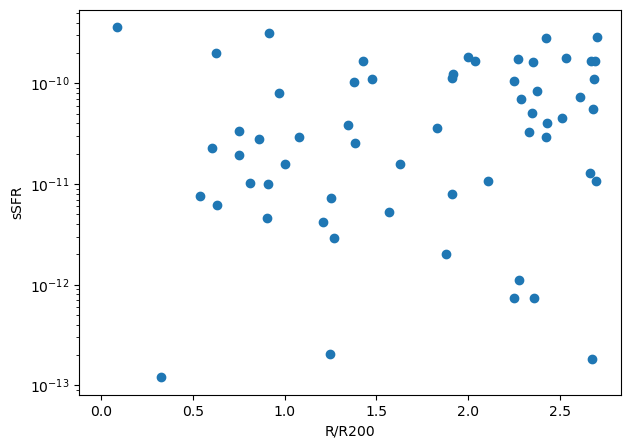

In [23]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.scatter(normpos_group_0, ssfr_group_0)
ax.set_yscale('log')
ax.set_xlabel('R/R200')
ax.set_ylabel('sSFR')

# testing for all the satellite galaxies

In [24]:
F05r200 = df_groups['05FossilR200']
NF05r200 = df_groups['05NFossilR200']

In [25]:
Fr200 = df_groups['1FossilR200']
NFr200 = df_groups['1NFossilR200']

### create list to calculate statistic parameters

In [26]:
QF_05_list = list(FS05_qf.values())

In [27]:
QF_NF05_list = list(NFS05_qf.values())

In [28]:
medianQF = np.median(QF_05_list)
mediannQF = np.median(QF_NF05_list)
meanQF = np.mean(QF_05_list)
meannQF = np.mean(QF_NF05_list)

In [29]:
QF_1_list = list(FS1_qf.values())

In [30]:
QF_NF1_list = list(NFS1_qf.values())

In [31]:
medianQF = np.median(QF_1_list)
mediannQF = np.median(QF_NF1_list)
meanQF = np.mean(QF_1_list)
meannQF = np.mean(QF_NF1_list)

In [32]:
weight_fossil = np.ones_like(QF_05_list)/len(F05r200)
weight_nonfossil = np.ones_like(QF_NF05_list)/len(NF05r200)
#bins= np.arange(0, 1, 0.025)
bins= int(1 + np.log2(len(F05r200)+len(NF05r200)))

In [33]:
weight_fossil_1 = np.ones_like(QF_1_list)/len(Fr200)
weight_nonfossil_1 = np.ones_like(QF_NF1_list)/len(NFr200)
#bins= np.arange(0, 1, 0.025)
bins_1 = int(1 + np.log2(len(Fr200)+len(NFr200)))

Text(0.5, 0.01, 'quenching fraction (% of quenched galaxies per halo)')

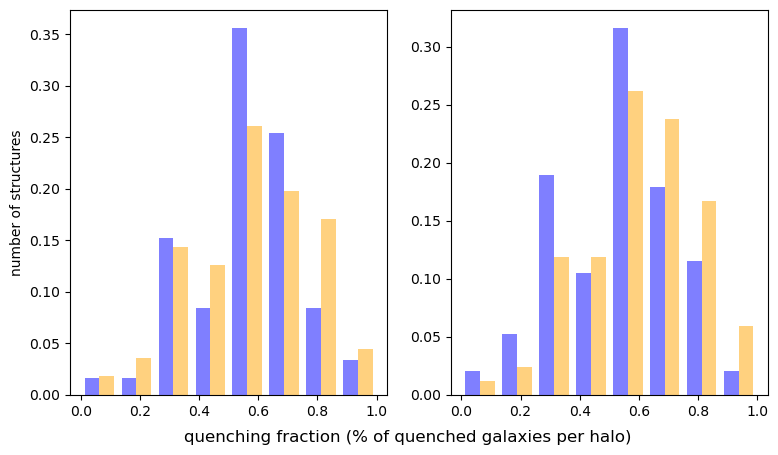

In [34]:
fig, ax = plt.subplots(1,2, figsize=(9,5))

ax[0].hist([QF_NF05_list,QF_05_list], bins=bins, color = ['blue', 'orange'], 
           rwidth=0.8, alpha=0.5, label=['Non fossil', 'Fossil'], 
           weights = [weight_nonfossil, weight_fossil], cumulative=False)
ax[1].hist([QF_NF1_list,QF_1_list], bins=bins, color = ['blue', 'orange'], 
           rwidth=0.8, alpha=0.5, label=['Non fossil', 'Fossil'], 
           weights = [weight_nonfossil_1, weight_fossil_1], cumulative=False)

ax[0].set_ylabel('number of structures')
fig.supxlabel('quenching fraction (% of quenched galaxies per halo)')


In [35]:
df_05 = pd.DataFrame({
    'QF': QF_NF05_list + QF_05_list,
    'state': ['non fosil'] * len(QF_NF05_list) + ['fosil'] * len(QF_05_list)
})

df_1 = pd.DataFrame({
    'QF': QF_NF1_list + QF_1_list,
    'state': ['non fosil'] * len(QF_NF1_list) + ['fosil'] * len(QF_1_list)
})

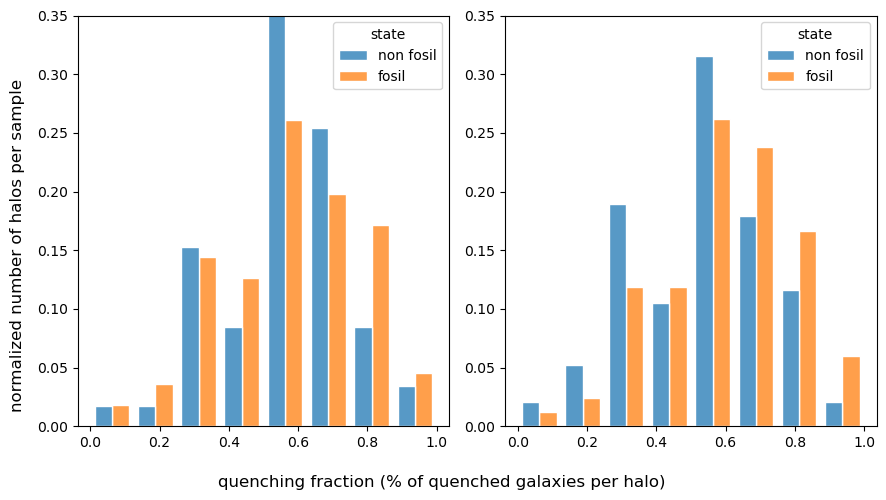

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(9, 5))

sns.histplot(data=df_05, x='QF', hue='state', 
             bins=bins, stat='proportion', element='bars', 
             common_norm=False, ax=ax[0], multiple='dodge', 
             shrink=0.8, edgecolor='white')

sns.histplot(data=df_1, x='QF', hue='state',
             bins=bins, stat='proportion', element='bars',
             common_norm=False, ax=ax[1], multiple='dodge', 
             shrink=0.8, edgecolor='white')

# Quitar etiquetas de ejes individuales
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_ylim(0,0.35)

ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_ylim(0,0.35)
# Etiqueta común en el eje x
fig.supylabel('normalized number of halos per sample')
fig.supxlabel('quenching fraction (% of quenched galaxies per halo)')

plt.tight_layout()
plt.show()


## cumulative quenching fraction

In [37]:
binsnf = np.linspace(0, 1, num=len(QF_NF05_list))
binsf = np.linspace(0, 1, num=len(QF_05_list))

binsnf1 = np.linspace(0, 1, num=len(QF_NF1_list))
binsf1 = np.linspace(0, 1, num=len(QF_1_list))

In [38]:
bins= np.linspace(0, 1, num=50)

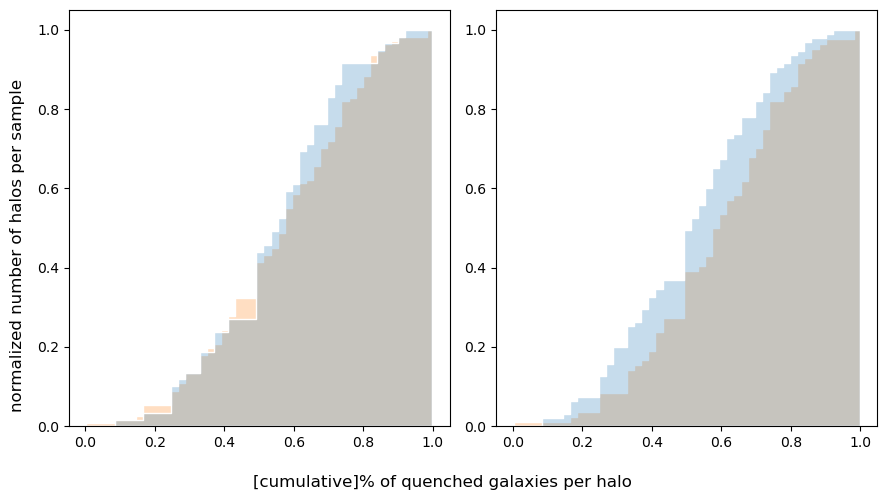

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(9, 5))

sns.histplot(data=df_05, x='QF', hue='state', 
             bins=bins, stat='proportion', element='step', 
             common_norm=False, ax=ax[0], multiple='layer', 
             shrink=0.8, edgecolor='white', cumulative=True, legend='')

sns.histplot(data=df_1, x='QF', hue='state',
             bins=bins, stat='proportion', element='step',
             common_norm=False, ax=ax[1], multiple='layer', 
             shrink=0.8, edgecolor='white', cumulative=True, legend='')

# Quitar etiquetas de ejes individuales
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_ylim(0,1.05)

ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_ylim(0,1.05)
# Etiqueta común en el eje x
fig.supylabel('normalized number of halos per sample')
fig.supxlabel('[cumulative]% of quenched galaxies per halo')

plt.tight_layout()
plt.show()

In [40]:
# Funcion para calcular histograma y diferencia
def compute_hist_and_diff(df, bins):
    fosil = df[df['state'] == 'fosil']['QF']
    nofosil = df[df['state'] == 'non fosil']['QF']
    
    h_fosil, _ = np.histogram(fosil, bins=bins, density=True)
    h_nofosil, _ = np.histogram(nofosil, bins=bins, density=True)
    
    return fosil, nofosil, h_fosil, h_nofosil, h_fosil - h_nofosil

/home/tnguser/taller/utilthings/star_formation/ipykernel_11433/2253826186.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


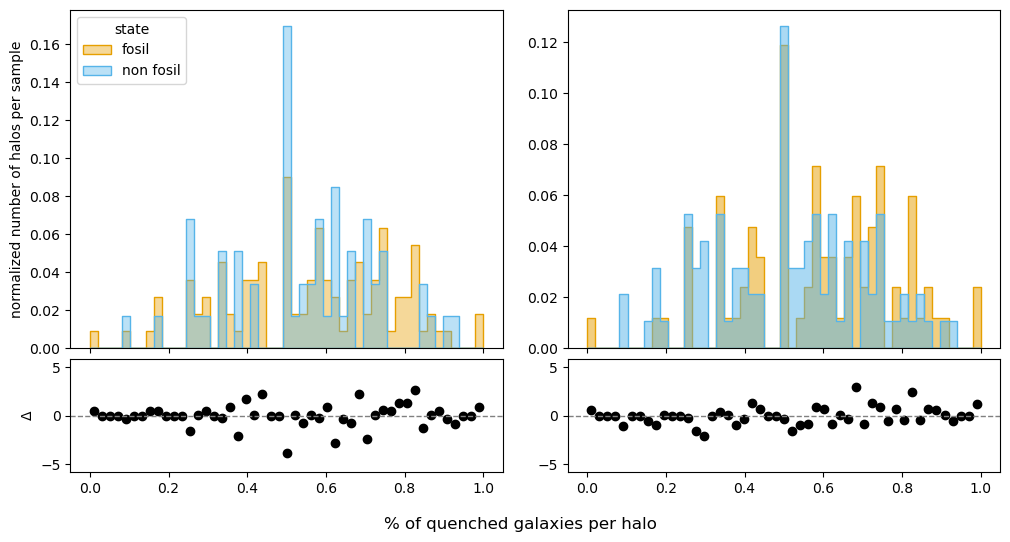

In [41]:
palette = {'fosil': '#E69F00', 'non fosil': '#56B4E9'}

# Bins comunes para ambas comparaciones
bins = np.linspace(0, 1, 50)
bin_centers = 0.5 * (bins[1:] + bins[:-1])


# Calcular para ambas muestras
f05, nf05, h_f05, h_nf05, diff_05 = compute_hist_and_diff(df_05, bins)
f1, nf1, h_f1, h_nf1, diff_1 = compute_hist_and_diff(df_1, bins)

# Crear figura con 2 columnas y 2 filas
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 2, height_ratios=[3, 1], hspace=0.05, wspace=0.15)

# Panel 05
ax_05_main = fig.add_subplot(gs[0, 0])
ax_05_diff = fig.add_subplot(gs[1, 0], sharex=ax_05_main)

sns.histplot(f05, bins=bins, stat='proportion', element='step', fill=True,
             color=palette['fosil'], label='fosil', ax=ax_05_main, 
             cumulative=False, alpha=0.4)
sns.histplot(nf05, bins=bins, stat='proportion', element='step', fill=True,
             color=palette['non fosil'], label='non fosil', ax=ax_05_main, 
             cumulative=False, alpha=0.4)

ax_05_diff.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_05_diff.scatter(bin_centers, diff_05, color='black')

# Panel 1
ax_1_main = fig.add_subplot(gs[0, 1])
ax_1_diff = fig.add_subplot(gs[1, 1], sharex=ax_1_main)

sns.histplot(f1, bins=bins, stat='proportion', element='step', fill=True,
             color=palette['fosil'], label='fosil', ax=ax_1_main, 
             cumulative=False, alpha=0.5)
sns.histplot(nf1, bins=bins, stat='proportion', element='step', fill=True,
             color=palette['non fosil'], label='non fosil', ax=ax_1_main, 
             cumulative=False, alpha=0.5)

ax_1_diff.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_1_diff.scatter(bin_centers, diff_1, color='black')

# Etiquetas y leyenda
ax_05_main.set_ylabel('normalized number of halos per sample')
ax_05_diff.set_ylabel('Δ')
fig.supxlabel('% of quenched galaxies per halo')


# Limpiar etiquetas X arriba
ax_05_main.set_xlabel('')
ax_1_main.set_xlabel('')
plt.setp(ax_05_main.get_xticklabels(), visible=False)
plt.setp(ax_1_main.get_xticklabels(), visible=False)

ax_1_main.set_ylabel('')
ax_1_diff.set_ylabel('')

ax_05_diff.set_ylim(-5.8, 5.8)
ax_1_diff.set_ylim(-5.8, 5.8)
# Leyenda solo en uno
ax_05_main.legend(title='state', loc='upper left')

plt.tight_layout()
plt.show()

In [42]:
def compute_cdf_and_diff(df, bins):
    fosil = df[df['state'] == 'fosil']['QF']
    nofosil = df[df['state'] == 'non fosil']['QF']
    
    # Histograma normalizado
    h_fosil, _ = np.histogram(fosil, bins=bins, density=True)
    h_nofosil, _ = np.histogram(nofosil, bins=bins, density=True)
    
    # CDF (suma acumulada de las proporciones)
    cdf_fosil = np.cumsum(h_fosil * np.diff(bins))
    cdf_nofosil = np.cumsum(h_nofosil * np.diff(bins))
    
    return fosil, nofosil, cdf_fosil, cdf_nofosil, cdf_fosil - cdf_nofosil

/home/tnguser/taller/utilthings/star_formation/ipykernel_11433/35750756.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


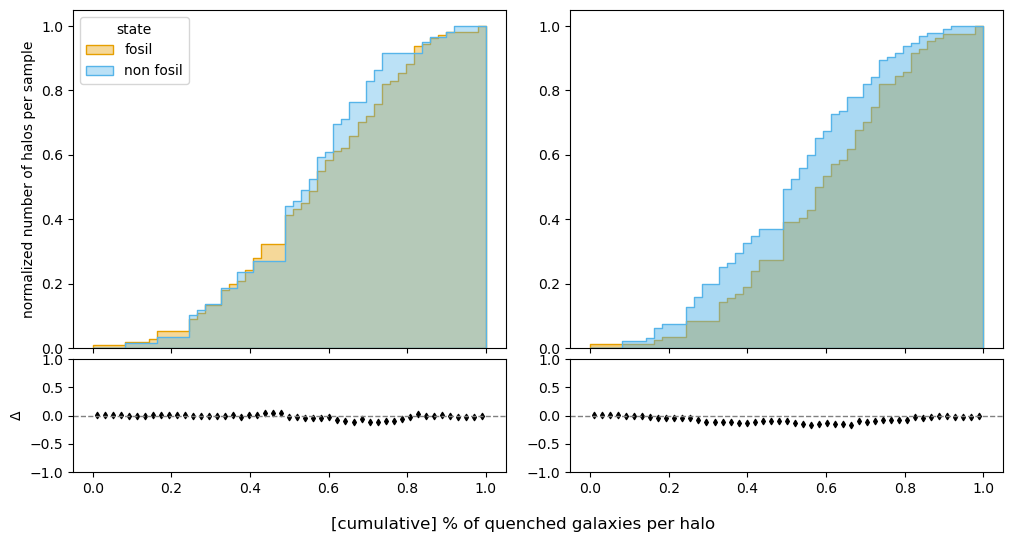

In [43]:
palette = {'fosil': '#E69F00', 'non fosil': '#56B4E9'}

# Bins comunes para ambas comparaciones
bins = np.linspace(0, 1, 50)
bin_centers = 0.5 * (bins[1:] + bins[:-1])


# Calcular para ambas muestras con CDF
f05, nf05, cdf_f05, cdf_nf05, diff_05 = compute_cdf_and_diff(df_05, bins)
f1, nf1, cdf_f1, cdf_nf1, diff_1 = compute_cdf_and_diff(df_1, bins)


# Crear figura con 2 columnas y 2 filas
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 2, height_ratios=[3, 1], hspace=0.05, wspace=0.15)

# Panel 05
ax_05_main = fig.add_subplot(gs[0, 0])
ax_05_diff = fig.add_subplot(gs[1, 0], sharex=ax_05_main)

sns.histplot(f05, bins=bins, stat='proportion', element='step', fill=True,
             color=palette['fosil'], label='fosil', ax=ax_05_main, 
             cumulative=True, alpha=0.4)
sns.histplot(nf05, bins=bins, stat='proportion', element='step', fill=True,
             color=palette['non fosil'], label='non fosil', ax=ax_05_main, 
             cumulative=True, alpha=0.4)

ax_05_diff.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_05_diff.scatter(bin_centers, diff_05, color='black', s=10, marker='d')

# Panel 1
ax_1_main = fig.add_subplot(gs[0, 1])
ax_1_diff = fig.add_subplot(gs[1, 1], sharex=ax_1_main)

sns.histplot(f1, bins=bins, stat='proportion', element='step', fill=True,
             color=palette['fosil'], label='fosil', ax=ax_1_main, 
             cumulative=True, alpha=0.5)
sns.histplot(nf1, bins=bins, stat='proportion', element='step', fill=True,
             color=palette['non fosil'], label='non fosil', ax=ax_1_main, 
             cumulative=True, alpha=0.5)

ax_1_diff.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_1_diff.scatter(bin_centers, diff_1, color='black', s=10, marker='d')


# Etiquetas y leyenda
ax_05_main.set_ylabel('normalized number of halos per sample')
ax_05_diff.set_ylabel('Δ')
fig.supxlabel('[cumulative] % of quenched galaxies per halo')


# Limpiar etiquetas X arriba
ax_05_main.set_xlabel('')
ax_1_main.set_xlabel('')
plt.setp(ax_05_main.get_xticklabels(), visible=False)
plt.setp(ax_1_main.get_xticklabels(), visible=False)

ax_1_main.set_ylabel('')
ax_1_diff.set_ylabel('')

ax_05_diff.set_ylim(-1, 1)
ax_1_diff.set_ylim(-1, 1)
# Leyenda solo en uno
ax_05_main.legend(title='state', loc='upper left')


plt.tight_layout()
plt.show()


## ks-tests

In [44]:
from scipy.stats import kstest
from scipy.stats import ks_2samp

In [45]:
print(ks_2samp(QF_05_list, QF_NF05_list))
print(ks_2samp(QF_05_list, QF_NF05_list, alternative='less'))

KstestResult(statistic=0.12414109024278516, pvalue=0.5404117743657937, statistic_location=0.6538461538461539, statistic_sign=-1)
KstestResult(statistic=0.12414109024278516, pvalue=0.27570986024439215, statistic_location=0.6538461538461539, statistic_sign=-1)


In [46]:
print(ks_2samp(QF_1_list, QF_NF1_list))
print(ks_2samp(QF_1_list, QF_NF1_list, alternative='less'))

KstestResult(statistic=0.17644110275689223, pvalue=0.10687167453379458, statistic_location=0.5714285714285714, statistic_sign=-1)
KstestResult(statistic=0.17644110275689223, pvalue=0.053442414050948336, statistic_location=0.5714285714285714, statistic_sign=-1)


## lopes+2024 plot

In [47]:
df_05 = pd.DataFrame(columns = ['id', 'state', 'Rnorm', 'sSFR'])

In [48]:
df_05['id'] = [
    member['subhalo_id']
    for group_data in FS05_rnorm.values()
    for member in group_data
] + [
    member['subhalo_id']
    for group_data in NFS05_rnorm.values()
    for member in group_data
]
df_05['state'] = [
    member['state']
    for group_data in FS05_rnorm.values()
    for member in group_data
] + [
    member['state']
    for group_data in NFS05_rnorm.values()
    for member in group_data
]
df_05['Rnorm'] = [
    member['rnorm']
    for group_data in FS05_rnorm.values()
    for member in group_data
] + [
    member['rnorm']
    for group_data in NFS05_rnorm.values()
    for member in group_data
]
df_05['sSFR'] = [
    member['sSFR']
    for group_data in FS05_rnorm.values()
    for member in group_data
] + [
    member['sSFR']
    for group_data in NFS05_rnorm.values()
    for member in group_data
]

In [49]:
df_05_all = df_05.copy()  # con centrales
df_05_no_central = df_05[df_05['Rnorm'] > 0]  # sin centrales

### including central galaxy and excluding central

In [50]:
df_1 = pd.DataFrame(columns = ['id', 'state', 'Rnorm', 'sSFR'])

In [51]:
df_1['id'] = [
    member['subhalo_id']
    for group_data in FS1_rnorm.values()
    for member in group_data
] + [
    member['subhalo_id']
    for group_data in NFS1_rnorm.values()
    for member in group_data
]

df_1['state'] = [
    member['state']
    for group_data in FS1_rnorm.values()
    for member in group_data
] + [
    member['state']
    for group_data in NFS1_rnorm.values()
    for member in group_data
]

df_1['sSFR'] = [
    member['sSFR']
    for group_data in FS1_rnorm.values()
    for member in group_data
] + [
    member['sSFR']
    for group_data in NFS1_rnorm.values()
    for member in group_data
]

df_1['Rnorm'] = [
    member['rnorm']
    for group_data in FS1_rnorm.values()
    for member in group_data
] + [
    member['rnorm']
    for group_data in NFS1_rnorm.values()
    for member in group_data
]


In [52]:
df_1_all = df_1.copy()  # con centrales
df_1_no_central = df_1[df_1['Rnorm'] > 0]  # sin centrales

### structures selected at 05R200 with all galaxies

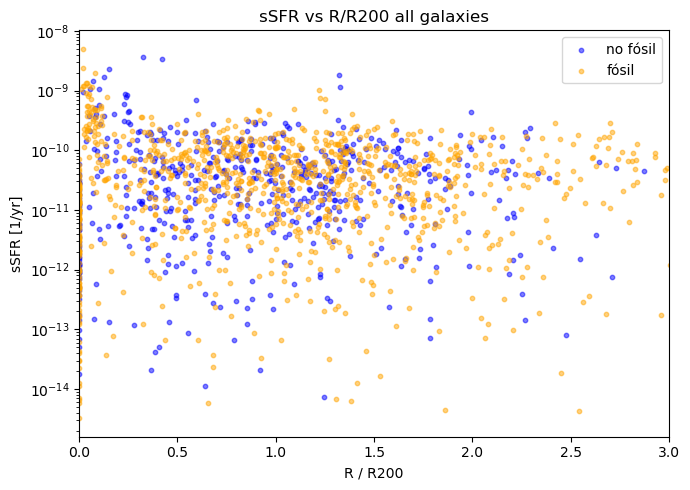

In [53]:
# Separar por estado
fs = df_05_all[df_05_all['state'] == 'FS']
nfs = df_05_all[df_05_all['state'] == 'nFS']

# Gráfico
plt.figure(figsize=(7, 5))
plt.scatter(nfs['Rnorm'], nfs['sSFR'], s=10, alpha=0.5, label='no fósil', c='blue')
plt.scatter(fs['Rnorm'], fs['sSFR'], s=10, alpha=0.5, label='fósil', c='orange')

plt.yscale('log')
plt.xlabel('R / R200')
plt.ylabel('sSFR [1/yr]')
plt.xlim(-0.001, 3)
plt.title('sSFR vs R/R200 all galaxies')
plt.legend()
plt.tight_layout()
plt.show()

### strctures at .5 without centrals

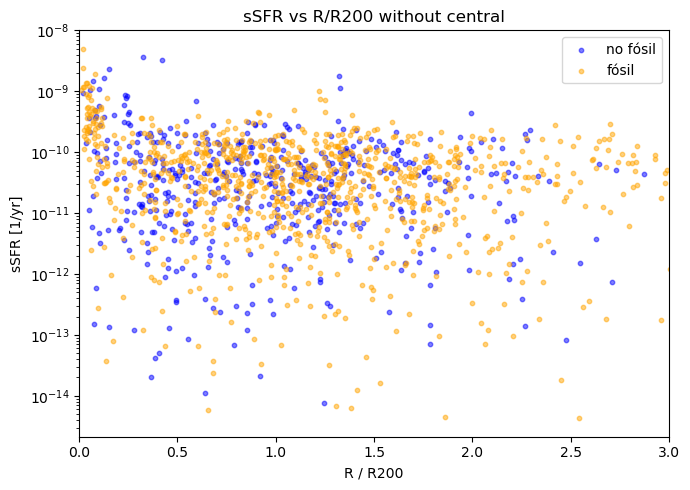

In [54]:
# state
fs = df_05_no_central[df_05_no_central['state'] == 'FS']
nfs = df_05_no_central[df_05_no_central['state'] == 'nFS']

plt.figure(figsize=(7, 5))
plt.scatter(nfs['Rnorm'], nfs['sSFR'], s=10, alpha=0.5, label='no fósil', c='blue')
plt.scatter(fs['Rnorm'], fs['sSFR'], s=10, alpha=0.5, label='fósil', c='orange')

plt.yscale('log')
plt.xlabel('R / R200')
plt.ylabel('sSFR [1/yr]')
plt.xlim(-0.001, 3)
plt.title('sSFR vs R/R200 without central')
plt.legend()
plt.tight_layout()
plt.show()

### structures selected at 1R200 with all galaxies

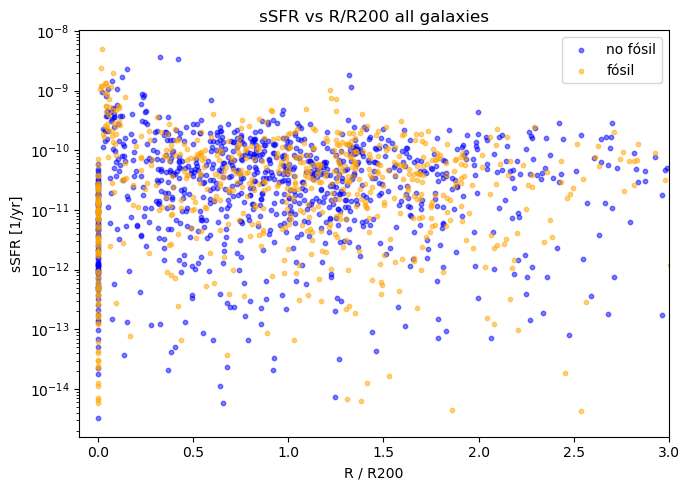

In [55]:
# Separar por estado
fs = df_1_all[df_1_all['state'] == 'FS']
nfs = df_1_all[df_1_all['state'] == 'nFS']

# Gráfico
plt.figure(figsize=(7, 5))
plt.scatter(nfs['Rnorm'], nfs['sSFR'], s=10, alpha=0.5, label='no fósil', c='blue')
plt.scatter(fs['Rnorm'], fs['sSFR'], s=10, alpha=0.5, label='fósil', c='orange')

plt.yscale('log')
plt.xlabel('R / R200')
plt.ylabel('sSFR [1/yr]')
plt.xlim(-0.1, 3)
plt.title('sSFR vs R/R200 all galaxies')
plt.legend()
plt.tight_layout()
plt.show()

### structures at 1 without central

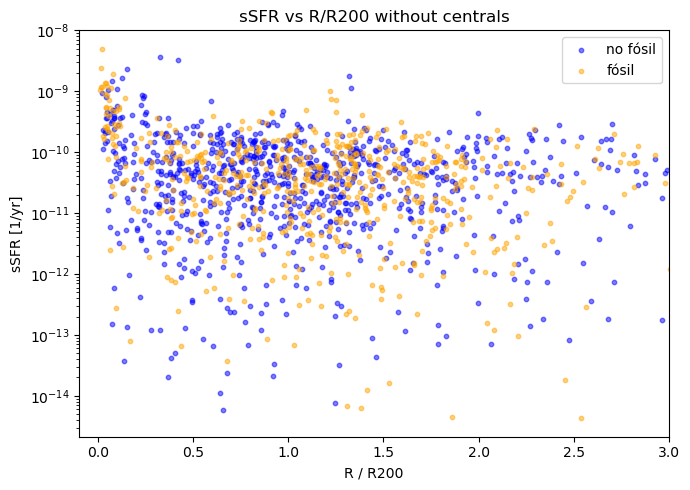

In [56]:
# state
fs = df_1_no_central[df_1_no_central['state'] == 'FS']
nfs = df_1_no_central[df_1_no_central['state'] == 'nFS']

plt.figure(figsize=(7, 5))
plt.scatter(nfs['Rnorm'], nfs['sSFR'], s=10, alpha=0.5, label='no fósil', c='blue')
plt.scatter(fs['Rnorm'], fs['sSFR'], s=10, alpha=0.5, label='fósil', c='orange')

plt.yscale('log')
plt.xlabel('R / R200')
plt.ylabel('sSFR [1/yr]')
plt.xlim(-0.1, 3)
plt.title('sSFR vs R/R200 without centrals')
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
def binned_ssfr_fraction_stats_df(df, col_rnorm, col_ssfr, bins, threshold=1e-11):
    """
    Calcula la fracción de galaxias con sSFR > threshold por bin de Rnorm,
    junto con el error binomial.

    Parámetros
    ----------
    df : DataFrame
        DataFrame que contiene las columnas especificadas.
    col_rnorm : str
        Nombre de la columna con la distancia normalizada (Rnorm).
    col_ssfr : str
        Nombre de la columna con sSFR.
    bins : array-like
        Límites de los bins en Rnorm.
    threshold : float, opcional
        Umbral de sSFR para considerar una galaxia como activa.

    Retorna
    -------
    bin_centers : np.ndarray
        Centro de cada bin.
    fracs : np.ndarray
        Fracción de galaxias con sSFR > threshold en cada bin.
    errors : np.ndarray
        Error binomial de la fracción en cada bin.
    counts : np.ndarray
        Número total de galaxias en cada bin.
    """
    # Asignar bin a cada galaxia
    bin_indices = np.digitize(df[col_rnorm], bins)

    bin_centers = []
    fracs = []
    errors = []
    counts = []

    # Recorrer cada bin
    for i in range(1, len(bins)):
        bin_center = 0.5 * (bins[i-1] + bins[i])
        bin_data = df[bin_indices == i]
        
        total = bin_data.shape[0]
        sf_count = (bin_data[col_ssfr] > threshold).sum()
        frac = sf_count / total if total > 0 else np.nan
        error = np.sqrt(frac * (1 - frac) / total) if total > 0 else np.nan

        bin_centers.append(bin_center)
        fracs.append(frac)
        errors.append(error)
        counts.append(total)

    return (
        np.array(bin_centers),
        np.array(fracs),
        np.array(errors),
        np.array(counts)
    )

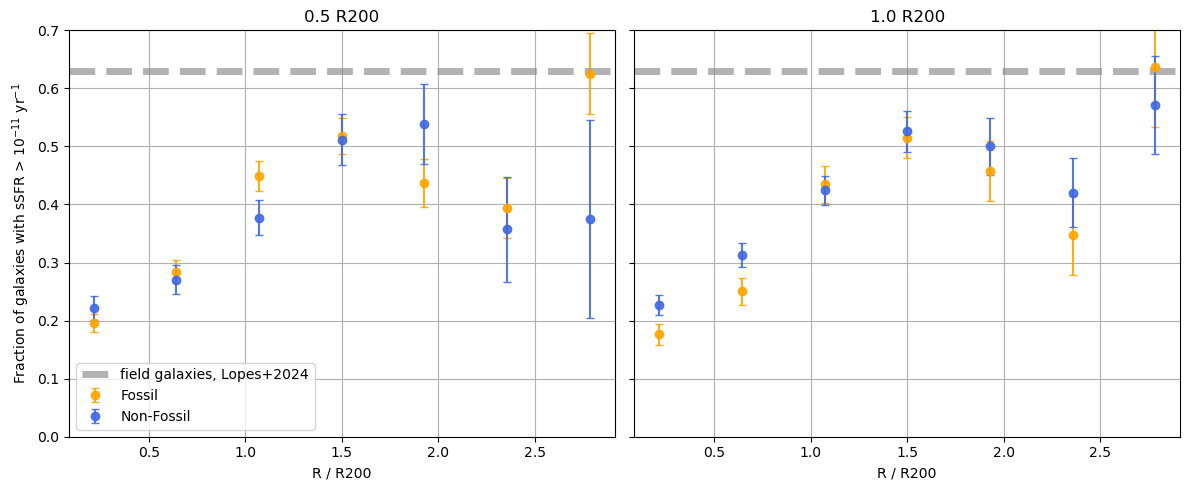

In [58]:
# Parametros
threshold = 1e-11
bins = np.linspace(0, 3, 8)  # ejemplo de cortes en Rnorm

# --- Separar muestras ---
fs_05  = df_05_no_central[df_05_no_central['state'] == 'FS']
nfs_05 = df_05_no_central[df_05_no_central['state'] == 'nFS']

fs_1  = df_1_no_central[df_1_no_central['state'] == 'FS']
nfs_1 = df_1_no_central[df_1_no_central['state'] == 'nFS']

# --- Calcular bins equipoblacionales ---

centers_f05, frac_f05, errors_f05, counts_f05 = binned_ssfr_fraction_stats_df(
    fs_05, 
    col_rnorm='Rnorm', 
    col_ssfr='sSFR', 
    bins=bins
)

centers_nf05, frac_nf05,  errors_nf05, counts_nf05 = binned_ssfr_fraction_stats_df(
    nfs_05, 
    col_rnorm='Rnorm', 
    col_ssfr='sSFR', 
    bins=bins
)


centers_f1, frac_f1, errors_f1, counts_f1 = binned_ssfr_fraction_stats_df(
    fs_1, 
    col_rnorm='Rnorm', 
    col_ssfr='sSFR', 
    bins=bins
)

centers_nf1, frac_nf1, errors_nf1, counts_nf1 = binned_ssfr_fraction_stats_df(
    nfs_1, 
    col_rnorm='Rnorm', 
    col_ssfr='sSFR', 
    bins=bins
)


# ------
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Panel 0.5R200
for centers, frac, err, color, label in [
    (centers_f05, frac_f05, errors_f05, 'orange', 'Fossil'),
    (centers_nf05, frac_nf05, errors_nf05, 'royalblue', 'Non-Fossil')
]:
    ax[0].errorbar(centers, frac, yerr=err, 
                   fmt='o', color=color, label=label, capsize=3, alpha=0.9)
    
ax[0].set_title('0.5 R200')
ax[0].set_xlabel('R / R200')
ax[0].set_ylabel('Fraction of galaxies with sSFR > $10^{-11}$ yr$^{-1}$')
ax[0].grid(True)
ax[0].set_ylim(0, 0.7)
ax[0].axhline(y=0.63, label='field galaxies, Lopes+2024', 
              linestyle='--', linewidth=5, color='gray', alpha=0.6)
ax[0].legend()

# Panel 1R200
for centers, frac, err, color, label in [
    (centers_f1, frac_f1, errors_f1, 'orange', 'Fossil'),
    (centers_nf1, frac_nf1, errors_nf1, 'royalblue', 'Non-Fossil')
]:
    ax[1].errorbar(centers, frac, yerr=err, 
                   fmt='o', color=color, label=label, capsize=3, alpha=0.9)
    
ax[1].set_title('1.0 R200')
ax[1].set_xlabel('R / R200')
ax[1].grid(True)
ax[1].set_ylim(0, 0.7)
ax[1].axhline(y=0.63, label='field galaxies, Lopes+2024', 
              linestyle='--', linewidth=5, color='gray', alpha=0.6)

plt.tight_layout()
plt.savefig('ssfr_fraction_equalbins.png', dpi=300)
plt.show()
